In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from adapt_utils.plotting import *

In [2]:
from firedrake import *

In [3]:
Hs = UnitSquareMesh(3, 1, diagonal='left')
Ht = UnitSquareMesh(1, 2, diagonal='right')
Vs = FunctionSpace(Hs, "CG", 1)
Vt = FunctionSpace(Ht, "CG", 1)

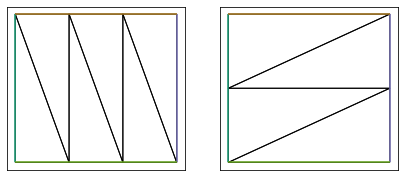

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3))
for i, H in enumerate((Hs, Ht)):
    triplot(H, axes=axes[i])
    axes[i].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=False)
    axes[i].tick_params(axis='y', which='both', left=False, right=False, labelleft=False, labelright=False)

In [5]:
def get_interpolation_matrix(VS, VT, tol=1e-10):
    try:
        assert VS.ufl_element().family() == 'Lagrange'
        assert VS.ufl_element().degree() == 1
        assert VT.ufl_element().family() == 'Lagrange'
        assert VT.ufl_element().degree() == 1
    except AssertionError:
        raise NotImplementedError
        
    target_coords = VT.mesh().coordinates.dat.data
    P_ST = np.zeros((VT.mesh().num_vertices(), VS.mesh().num_vertices()))
    phi_S = Function(Vs)  # Basis function for source space
    for i in range(VT.mesh().num_vertices()):
        for j in range(VS.mesh().num_vertices()):
            phi_S.dat.data[j] = 1
            P_ST[i, j] = phi_S.at(target_coords[i], tolerance=tol)
            phi_S.dat.data[j] = 0
    return P_ST

In [6]:
def print_matrix(A):
    m, n = A.shape

    for i in range(m):
        row_str = ""
        for j in range(n):
            row_str += "{:5.2f}  ".format(A[i, j])
        print(row_str + "\n")

In [7]:
P_st = get_interpolation_matrix(Vs, Vt)
print_matrix(P_st)

 0.00   0.00   0.00   0.00   0.00  -0.00   0.00   1.00  

-0.00   0.50   0.50   0.00   0.00   0.00   0.00   0.00  

-0.00   0.00   1.00   0.00   0.00   0.00   0.00   0.00  

 0.00   0.00   0.00   0.00   0.00   0.00   0.50   0.50  

-0.00   1.00   0.00   0.00   0.00   0.00   0.00   0.00  

 0.00   0.00   0.00   0.00   0.00  -0.00   1.00   0.00  



Take some `Function` defined on the source space.

In [8]:
s = Function(Vs, name="Source")
s.interpolate(SpatialCoordinate(Hs)[0]);

Apply the interpolation operator

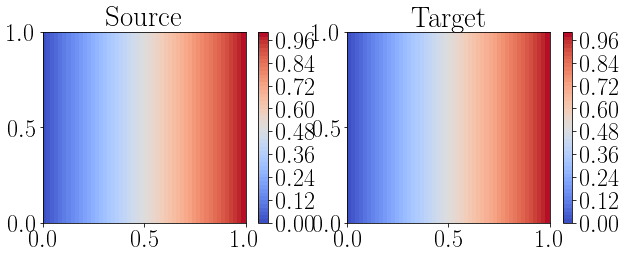

In [9]:
t = Function(Vt, name='Target')
t.dat.data[:] = np.dot(P_st, s.dat.data)

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))
for i, f in enumerate((s, t)):
    fig.colorbar(tricontourf(f, levels=50, axes=axes[i], cmap='coolwarm'), ax=axes[i]);
    axes[i].set_title(f.dat.name);

The function is linear, so linear interpolation is sufficient! It isn't for a function which is only _piecewise_ lienar, though. For example, consider interpolating just one basis function:

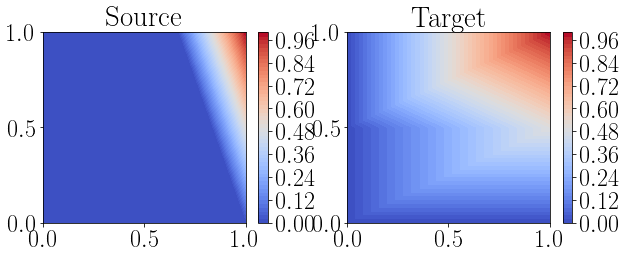

In [10]:
s.assign(0.0)
s.dat.data[1] = 1
t.dat.data[:] = np.dot(P_st, s.dat.data)
t.dat.name = 'Target'

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))
for i, f in enumerate((s, t)):
    fig.colorbar(tricontourf(f, levels=50, axes=axes[i], cmap='coolwarm'), ax=axes[i]);
    axes[i].set_title(f.dat.name);

In [11]:
P_ts = get_interpolation_matrix(Vt, Vs)

In [12]:
print("transpose(P_ST):")
print_matrix(P_st.transpose())
print("P_TS")
print_matrix(P_ts)

transpose(P_ST):
 0.00  -0.00  -0.00   0.00  -0.00   0.00  

 0.00   0.50   0.00   0.00   1.00   0.00  

 0.00   0.50   1.00   0.00   0.00   0.00  

 0.00   0.00   0.00   0.00   0.00   0.00  

 0.00   0.00   0.00   0.00   0.00   0.00  

-0.00   0.00   0.00   0.00   0.00  -0.00  

 0.00   0.00   0.00   0.50   0.00   1.00  

 1.00   0.00   0.00   0.50   0.00   0.00  

P_TS
 1.00   0.00   0.00   0.00   0.00   0.00  

-0.00   1.00   0.00   0.00   0.00   0.00  

-0.00   0.00   1.00   0.00   0.00   0.00  

-0.00   0.00   0.00   1.00   0.00   0.00  

 0.00   0.00   0.00  -0.00   1.00   0.00  

 0.00   0.00   0.00   0.00   0.00   1.00  

 0.00   0.00   0.00   0.00   0.00  -0.00  

 0.00   0.00   0.00   0.00   0.00  -0.00  



Try multiplying with the transpose:

In [13]:
t.interpolate(SpatialCoordinate(Ht)[1]);

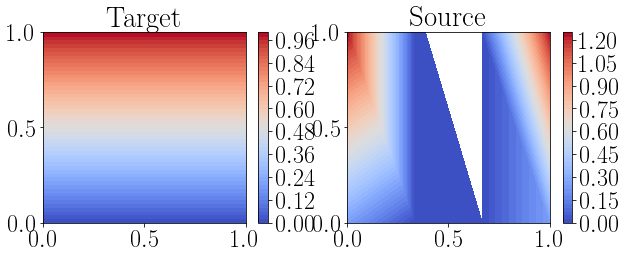

In [14]:
s.dat.data[:] = np.dot(P_st.T, t.dat.data)
s.dat.name = "Source"

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))
for i, f in enumerate((t, s)):
    fig.colorbar(tricontourf(f, levels=50, axes=axes[i], cmap='coolwarm'), ax=axes[i]);
    axes[i].set_title(f.dat.name);

# TODO: Sparse form!

# TODO: Use sparse PETSc Mat

Consider the same non-trivial problem from before

In [15]:
Hs = UnitSquareMesh(20, 25, diagonal='left')
Ht = UnitSquareMesh(20, 20, diagonal='right')
Vs = FunctionSpace(Hs, "CG", 1)
Vt = FunctionSpace(Ht, "CG", 1)
xs, ys = SpatialCoordinate(Hs)

In [16]:
s_init = Function(Vs, name="Initial source")
s_init.interpolate(sin(pi*xs)*sin(pi*ys))
s = Function(Vs, name="Source").assign(s_init)
t = Function(Vt, name="Target")

For a non-trivial problem, we better work matrix-free.

In [17]:
def interpolate_matfree(src, VT, tol=1.0e-10):
    try:
        assert src.ufl_element().family() == 'Lagrange'
        assert src.ufl_element().degree() == 1
        assert VT.ufl_element().family() == 'Lagrange'
        assert VT.ufl_element().degree() == 1
    except AssertionError:
        raise NotImplementedError
        
    tgt = Function(VT)
    target_coords = VT.mesh().coordinates.dat.data
    for i in range(VT.mesh().num_vertices()):
        tgt.dat.data[i] = src.at(target_coords[i], tolerance=tol)
        
    return tgt

In [ ]:
N = 1
l2_error = []
mass_error = []
mass_init = assemble(s_init*dx)
s.assign(s_init)
for i in range(N):
    t.assign(interpolate_matfree(s, Vt))
    s.assign(interpolate_matfree(t, Vs))
    l2_error.append(errornorm(s, s_init)/norm(s_init))
    mass_error.append(abs(assemble(s*dx) - mass_init)/abs(mass_init))

s.dat.name = "...after {:d} interpolations".format(N)
err = Function(s_init, name="Error")
err -= s

Initial source mass = 0.4039
...after 1 interpolations mass = 0.4026
Relative L2 error = 0.35%
Relative mass error = 0.32%


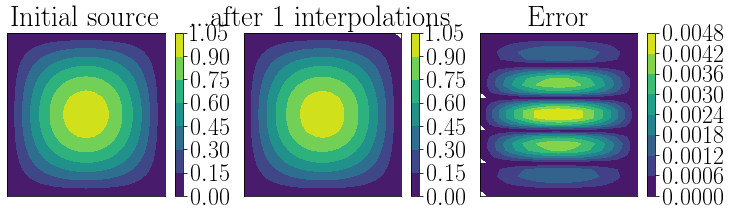

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
for i, f in enumerate((s_init, s, err)):
    ax = axes[i]
    fig.colorbar(tricontourf(f, axes=ax), ax=ax)
    ax.set_title(f.dat.name)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False, labelright=False)
    if f != err:
        print("{:s} mass = {:.4f}".format(f.dat.name, assemble(f*dx)))
print("Relative L2 error = {:.2f}%".format(100*l2_error[-1]))
print("Relative mass error = {:.2f}%".format(100*mass_error[-1]))

In [19]:
N = 9
for i in range(N):
    t.assign(interpolate_matfree(s, Vt))
    s.assign(interpolate_matfree(t, Vs))
    l2_error.append(errornorm(s, s_init)/norm(s_init))
    mass_error.append(abs(assemble(s*dx) - mass_init)/abs(mass_init))

s.dat.name = "...after {:d} interpolations".format(N+1)
err = Function(s_init, name="Error")
err -= s

Initial source mass = 0.4039
...after 10 interpolations mass = 0.3955
Relative L2 error = 2.25%
Relative mass error = 2.07%


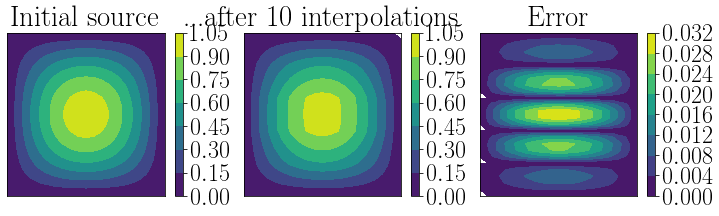

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
for i, f in enumerate((s_init, s, err)):
    ax = axes[i]
    fig.colorbar(tricontourf(f, axes=ax), ax=ax)
    ax.set_title(f.dat.name)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False, labelright=False)
    if f != err:
        print("{:s} mass = {:.4f}".format(f.dat.name, assemble(f*dx)))
print("Relative L2 error = {:.2f}%".format(100*l2_error[-1]))
print("Relative mass error = {:.2f}%".format(100*mass_error[-1]))

In [21]:
N = 90
for i in range(N):
    t.assign(interpolate_matfree(s, Vt))
    s.assign(interpolate_matfree(t, Vs))
    l2_error.append(errornorm(s, s_init)/norm(s_init))
    mass_error.append(abs(assemble(s*dx) - mass_init)/abs(mass_init))

s.dat.name = "...after {:d} interpolations".format(N+10)
err = Function(s_init, name="Error")
err -= s

Initial source mass = 0.4039
...after 100 interpolations mass = 0.3911
Relative L2 error = 3.46%
Relative mass error = 3.18%


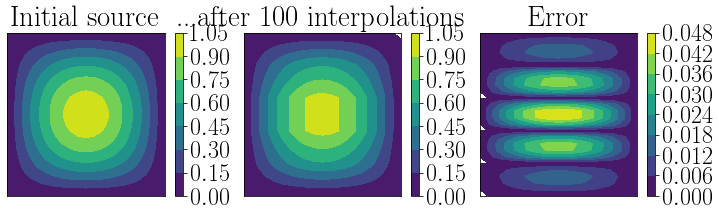

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
for i, f in enumerate((s_init, s, err)):
    ax = axes[i]
    fig.colorbar(tricontourf(f, axes=ax), ax=ax)
    ax.set_title(f.dat.name)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False, labelright=False)
    if f != err:
        print("{:s} mass = {:.4f}".format(f.dat.name, assemble(f*dx)))
print("Relative L2 error = {:.2f}%".format(100*l2_error[-1]))
print("Relative mass error = {:.2f}%".format(100*mass_error[-1]))

Initial source
...after 100 interpolations


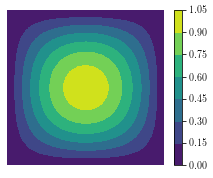

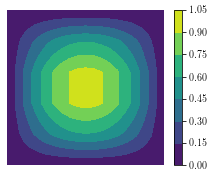

In [36]:
for f in (s_init, s):
    fig, axes = plt.subplots(figsize=(3.5, 3))
    cbar = fig.colorbar(tricontourf(f, axes=axes, levels=np.linspace(-1.0e-06, 1.05, 8)), ax=axes)
    cbar.set_ticks(np.linspace(0, 1.05, 8))
    cbar.ax.tick_params(labelsize=10)
    axes.axis(False)
    print(f.dat.name)
    savefig("_".join(f.dat.name.split()), "plots", ["png"])

Compare with the corresponding results for supermesh projection from the first notebook:

    Initial source mass = 0.4039
    ...after 100 projections mass = 0.4039
    Relative L2 error = 0.86%
    Relative mass error = 0.00%

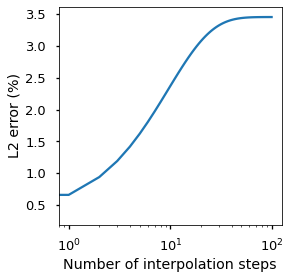

In [34]:
fig, axes = plt.subplots(figsize=(4, 4))
axes.semilogx(100*np.array(l2_error));
axes.set_xlabel("Number of interpolation steps")
axes.set_ylabel("L2 error (%)");

Observe the "flattening off" of the error. Let's see if it continues:

Initial source mass = 0.4039
...after 200 interpolations mass = 0.3911
Relative L2 error = 3.46%
Relative mass error = 3.18%


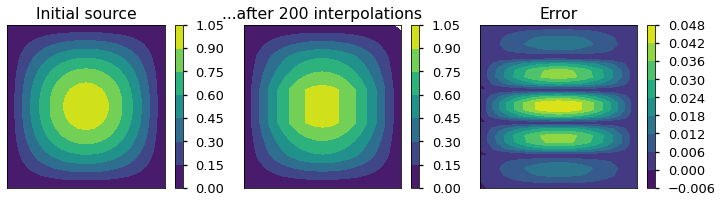

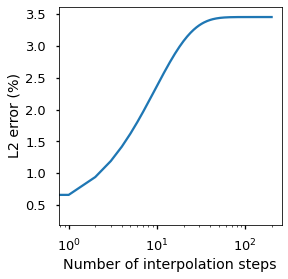

In [35]:
N = 100
for i in range(N):
    t.assign(interpolate_matfree(s, Vt))
    s.assign(interpolate_matfree(t, Vs))
    l2_error.append(errornorm(s, s_init)/norm(s_init))
    mass_error.append(abs(assemble(s*dx) - mass_init)/abs(mass_init))

s.dat.name = "...after {:d} interpolations".format(N+100)
err = Function(s_init, name="Error")
err -= s

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
for i, f in enumerate((s_init, s, err)):
    ax = axes[i]
    fig.colorbar(tricontourf(f, axes=ax), ax=ax)
    ax.set_title(f.dat.name)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False, labelright=False)
    if f != err:
        print("{:s} mass = {:.4f}".format(f.dat.name, assemble(f*dx)))
print("Relative L2 error = {:.2f}%".format(100*l2_error[-1]))
print("Relative mass error = {:.2f}%".format(100*mass_error[-1]))

fig, axes = plt.subplots(figsize=(4, 4))
axes.semilogx(100*np.array(l2_error));
axes.set_xlabel("Number of interpolation steps")
axes.set_ylabel("L2 error (%)");